## Generate Synthetic Hospital Data

This is a notebook for generating synthetic data for hospital variables.

In [1]:
import os
import re
import sys
import math
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter

from src import ecdf, pdf, plots, coding_hospitals as CODING

#### PARAMETERS

In [2]:
# directory where the input files are found
DATA_DIR = 'data'

# number of synthetic tuples to generate
NUM_SAMPLES = 5000

# output will be written here
OUTPUT_FILE = 'synthetic_hospital_target.csv'
print('Synthetic data will be written to "{0}".'.format(OUTPUT_FILE))

Synthetic data will be written to "synthetic_hospital_target.csv".


#### Counts from the Premier data

Synthetic tuples will be generated to match these distributions.

In [3]:
# fake premier: 1000 total
# fake AHA:     5000 total

# #
# # SOURCE DATA
# #
# URBRUR_COUNTS = {
#     CODING.UrbRur.URBAN.value : 700,
#     CODING.UrbRur.RURAL.value : 300,
# }

# TEACHING_COUNTS = {
#     CODING.Teaching.NO.value  : 750,
#     CODING.Teaching.YES.value : 250,
# }

# BEDS_COUNTS = {
#     CODING.Beds.BEDS_006_099.value  : 225,
#     CODING.Beds.BEDS_100_199.value  : 200,
#     CODING.Beds.BEDS_200_299.value  : 175,
#     CODING.Beds.BEDS_300_499.value  : 275,
#     CODING.Beds.BEDS_500_PLUS.value : 125,
# }

# REGION_COUNTS = {
#     CODING.Region.MIDWEST.value   : 250,
#     CODING.Region.SOUTH.value     : 450,
#     CODING.Region.NORTHEAST.value : 175,
#     CODING.Region.WEST.value      : 125,
# }

# OWNERSHIP_COUNTS = {
#     CODING.Ownership.GOVERNMENT.value : 180,
#     CODING.Ownership.PROFIT.value     : 250,
#     CODING.Ownership.NONPROFIT.value  : 570,
# }

#
# TARGET DATA
#
URBRUR_COUNTS = {
    CODING.UrbRur.URBAN.value : 650,
    CODING.UrbRur.RURAL.value : 350,
}

TEACHING_COUNTS = {
    CODING.Teaching.NO.value  : 830,
    CODING.Teaching.YES.value : 170,
}

BEDS_COUNTS = {
    CODING.Beds.BEDS_006_099.value  : 175,
    CODING.Beds.BEDS_100_199.value  : 250,
    CODING.Beds.BEDS_200_299.value  : 200,
    CODING.Beds.BEDS_300_499.value  : 300,
    CODING.Beds.BEDS_500_PLUS.value :  75,
}

REGION_COUNTS = {
    CODING.Region.MIDWEST.value   : 300,
    CODING.Region.SOUTH.value     : 400,
    CODING.Region.NORTHEAST.value : 125,
    CODING.Region.WEST.value      : 175,
}

OWNERSHIP_COUNTS = {
    CODING.Ownership.GOVERNMENT.value : 225,
    CODING.Ownership.PROFIT.value     : 300,
    CODING.Ownership.NONPROFIT.value  : 475,
}


# order count dicts to match
ALL_VAR_COUNTS = [
    URBRUR_COUNTS, TEACHING_COUNTS, BEDS_COUNTS,
    REGION_COUNTS, OWNERSHIP_COUNTS,
]

VARIABLES = [name for enumvar,name in CODING.VAR_NAMES.items()]

# Each variable dict *must* contain an identical number of entries.
# Get the total from the first variable in the list.
total = 0
for k,v in ALL_VAR_COUNTS[0].items():
    total += v

# check to see that all counts sum to the state total
for count_dict in ALL_VAR_COUNTS:
    var_total = sum([v for k,v in count_dict.items()])
    assert var_total == total
    #print('Var total: {0}, total: {1}'.format(var_total, total))
    
# each variable must have data
assert len(ALL_VAR_COUNTS) == len(VARIABLES)

#### Initialize the random number generator

In [4]:
rng = np.random.default_rng()

# print the seed for reference
print('RNG seed: {0}'.format(rng._bit_generator._seed_seq.entropy))

RNG seed: 115372102133734969210962628147169164689


#### Determine the number of bins for each variable

In [5]:
# bin counts in order of the variables
BIN_COUNTS = []

for enumvar,var_name in CODING.VAR_NAMES.items():
    BIN_COUNTS.append(CODING.BIN_COUNTS[enumvar])

# maximum-length variable name, used for prettyprinting
maxlen = max([len(var_name) for var_name in VARIABLES])

print('Bin counts: ')
for i in range(len(VARIABLES)):
    print('{0:>{2}} : {1}'.format(VARIABLES[i], BIN_COUNTS[i], maxlen))

Bin counts: 
   UrbRur : 2
 Teaching : 2
  TotBeds : 5
   Region : 4
Ownership : 3


## Compute Empirical CDF and Inverse CDF

These functions are required by the synthetic data generation method.

In [6]:
# same order as ordered_cols
ecdf_list = [
    ecdf.EmpiricalCDF(URBRUR_COUNTS),    
    ecdf.EmpiricalCDF(TEACHING_COUNTS),
    ecdf.EmpiricalCDF(BEDS_COUNTS),    
    ecdf.EmpiricalCDF(REGION_COUNTS),
    ecdf.EmpiricalCDF(OWNERSHIP_COUNTS),
]

#### Plots of the inverse CDFs for each variable

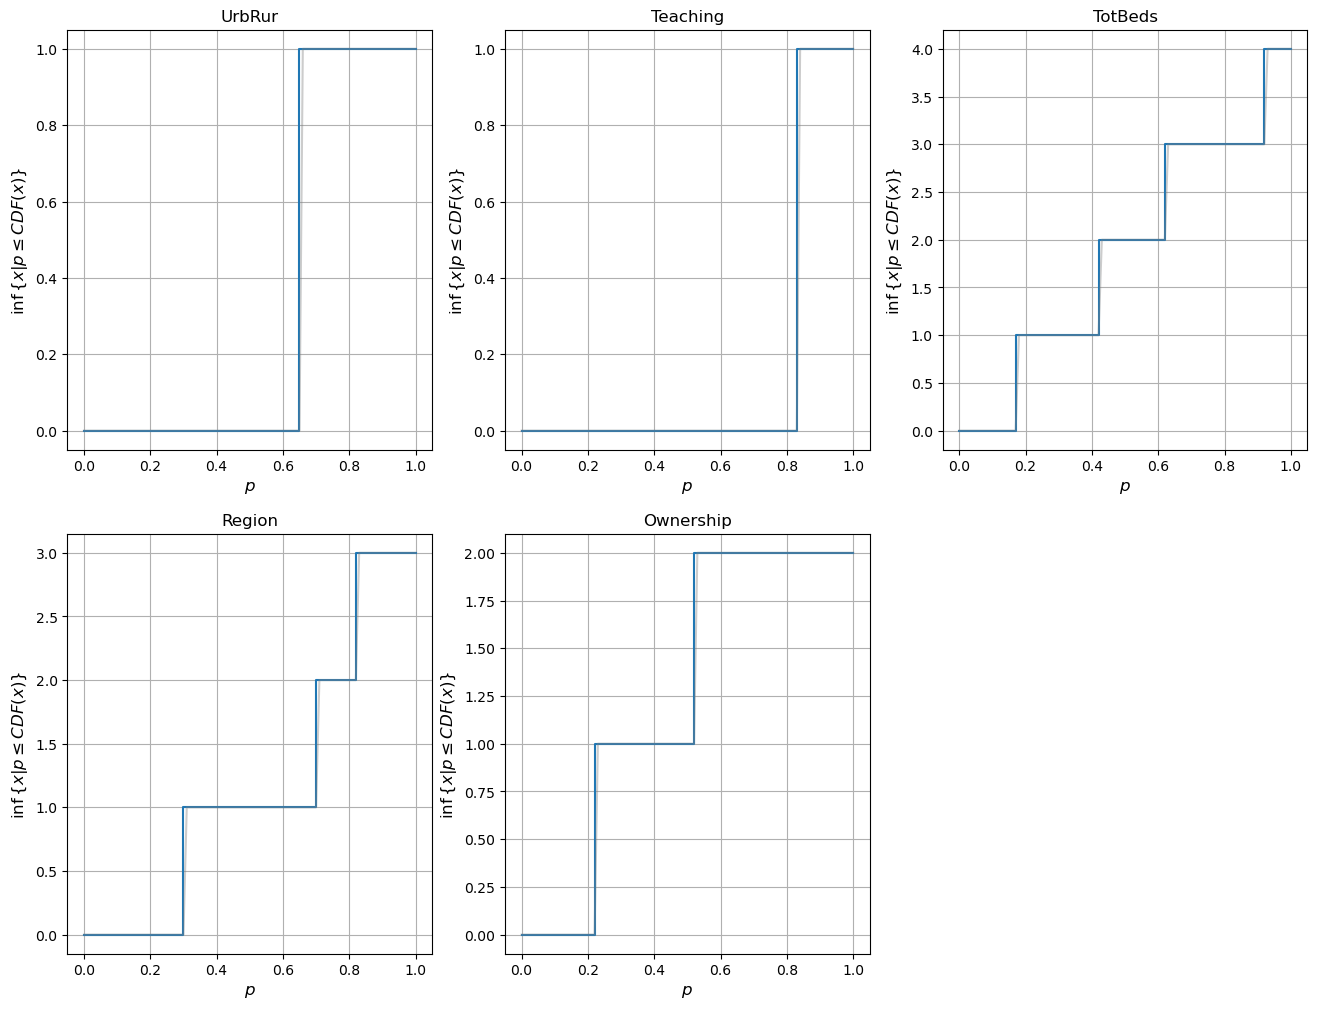

In [7]:
# probability values
plt.figure(figsize=(16, 12))
pvals = np.linspace(0, 1, 101)
for i, ecdf_obj in enumerate(ecdf_list):
    plt.subplot(2,3,i+1)
    # value of the inverse ECDF at each probability value
    yvals = [ecdf_obj.inv(p) for p in pvals]
    
    plt.step(pvals, yvals)
    # plot the generated values as a line plot
    plt.plot(pvals, yvals, color='grey', alpha=0.4)
    
    plt.xlabel('$p$', fontsize=12)
    plt.ylabel('$\inf \{ x | p \leq CDF(x)\}$', fontsize=12)
    plt.title('{0}'.format(VARIABLES[i]))
    plt.grid()
plt.show()

## Generate Synthetic Samples

Completely ignore correlations or any other dependencies in the data. Generate as many synthetic tuples as required to match the total count for this state.

In [8]:
print('Generating {0} synthetic tuples...'.format(NUM_SAMPLES))

Generating 5000 synthetic tuples...


In [9]:
# there are this many variables
dim = len(VARIABLES)

# 'frozen' distribution with zero mean and identity covariance
mv_normal = stats.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim))

# default 1D gaussian distribution with mean zero and std_dev 1
normal = stats.distributions.norm()

# multivariate normal tuples
Z = mv_normal.rvs(size=NUM_SAMPLES, random_state=rng)

In [10]:
# convert each component of the tuples in Z to a uniform distribution on [0,1]
U_list = []
for i in range(len(VARIABLES)):
    U_i = [normal.cdf(z) for z in Z[:,i]]
    U_list.append(U_i)

In [11]:
# transform each array in U_list using the inverse ECDF to project to the desired marginals
X_list = []
for i in range(dim):
    X_i = [ecdf_list[i].inv(u) for u in U_list[i]]
    X_list.append(X_i)

# generate tuples (one component for each variable, in order listed in VARIABLES)
synthetic_tuples = []
for i in range(NUM_SAMPLES):
    components = [X_list[k][i] for k in range(dim)]
    tup = tuple(components)
    synthetic_tuples.append(tup)
    
assert len(synthetic_tuples) == NUM_SAMPLES

#### Build output dataframe

In [12]:
final_df = pd.DataFrame(synthetic_tuples, columns=VARIABLES)
final_df

,UrbRur,Teaching,TotBeds,Region,Ownership
0,0,0,3,1,2
1,0,0,0,2,2
2,0,0,1,0,1
3,1,1,1,2,1
4,0,0,3,3,2
...,...,...,...,...,...
4995,1,0,2,3,2
4996,1,0,3,1,2
4997,1,0,2,0,2
4998,1,0,4,3,2


#### Adjust to desired length

In [13]:
# randomly shuffle the order of the tuples
output_df = final_df.sample(frac=1).reset_index(drop=True)

# # truncate to desired length
# if len(output_df) > len(state_indicators):
#     output_df = output_df.sample(n=len(state_indicators)).reset_index(drop=True)
    
# # assign state indicators
# output_df = output_df.assign(STATE = state_indicators)
    
output_df

,UrbRur,Teaching,TotBeds,Region,Ownership
0,0,1,3,1,2
1,1,0,1,0,2
2,1,0,3,1,1
3,0,0,3,1,2
4,1,0,1,0,0
...,...,...,...,...,...
4995,1,0,0,0,0
4996,1,0,3,1,2
4997,1,0,0,0,0
4998,0,0,1,3,0


#### Plot the original and synthetic PDFs for each variable

In [14]:
orig_pdfs = {}
synth_pdfs = {}

# compute weighted PDF for each variable
for i, var_name in enumerate(VARIABLES):
    
    # original pdf is from the count dict for this variable
    count_dict = ALL_VAR_COUNTS[i]
    pdf_o = np.zeros(len(count_dict))
    for val,count in count_dict.items():
        pdf_o[val] = count
    # normalize
    total = np.sum(pdf_o)
    pdf_o /= total
    orig_pdfs[var_name] = pdf_o
    
    # synthetic samples for variable i are the ith component of the synthetic tuples
    #synth_samples = [tup[i] for tup in synthetic_tuples]
    synth_samples = output_df[var_name].values
    num_bins = BIN_COUNTS[i]
        
    # synthetic PDF
    pdf_s = pdf.to_pdf(num_bins, synth_samples)
    synth_pdfs[var_name] = pdf_s

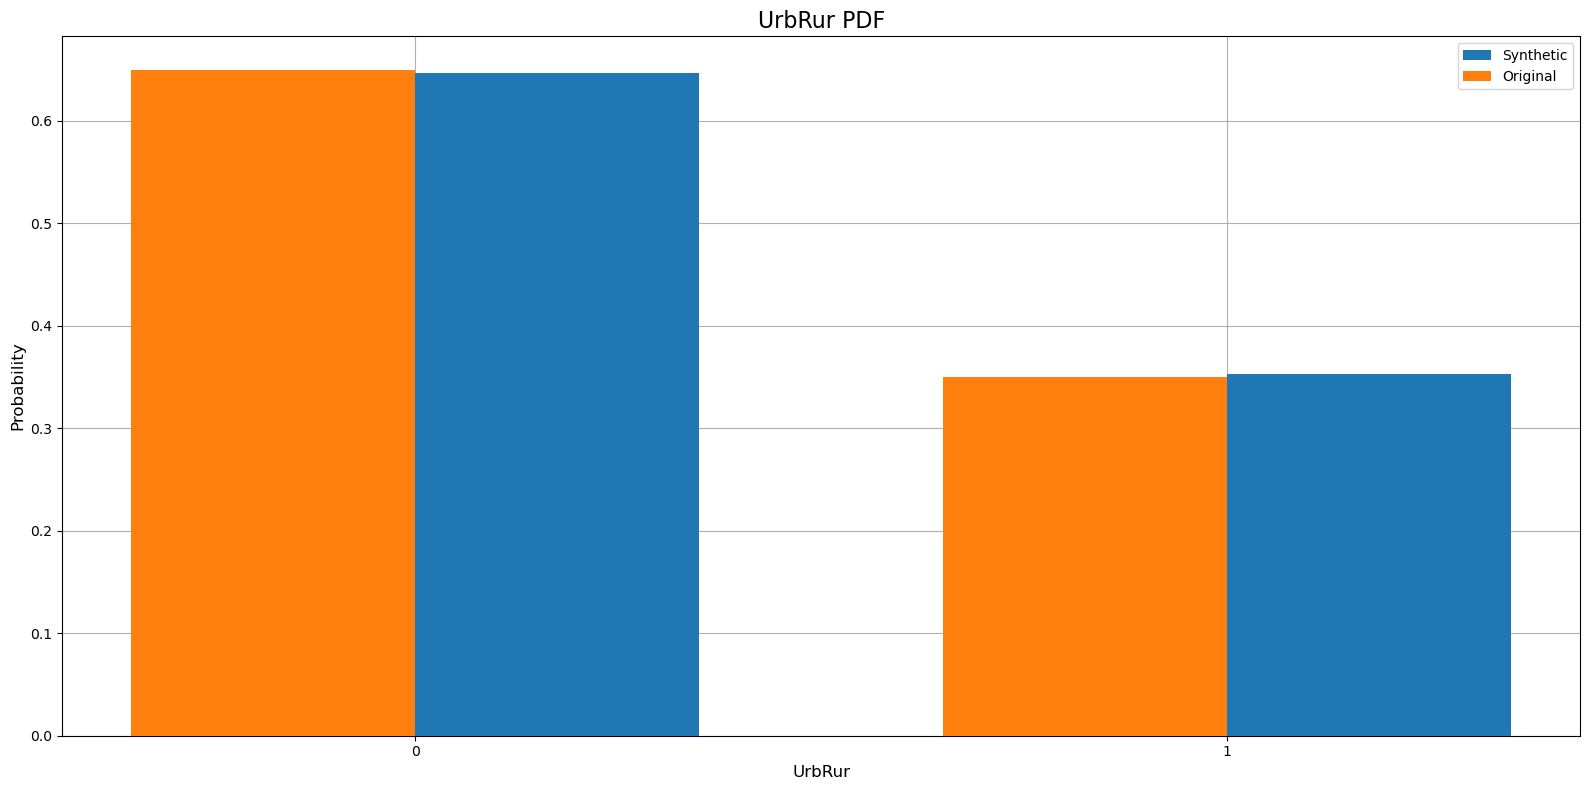

 Original PDF : [0.65 0.35]
Synthetic PDF : [0.647 0.353]


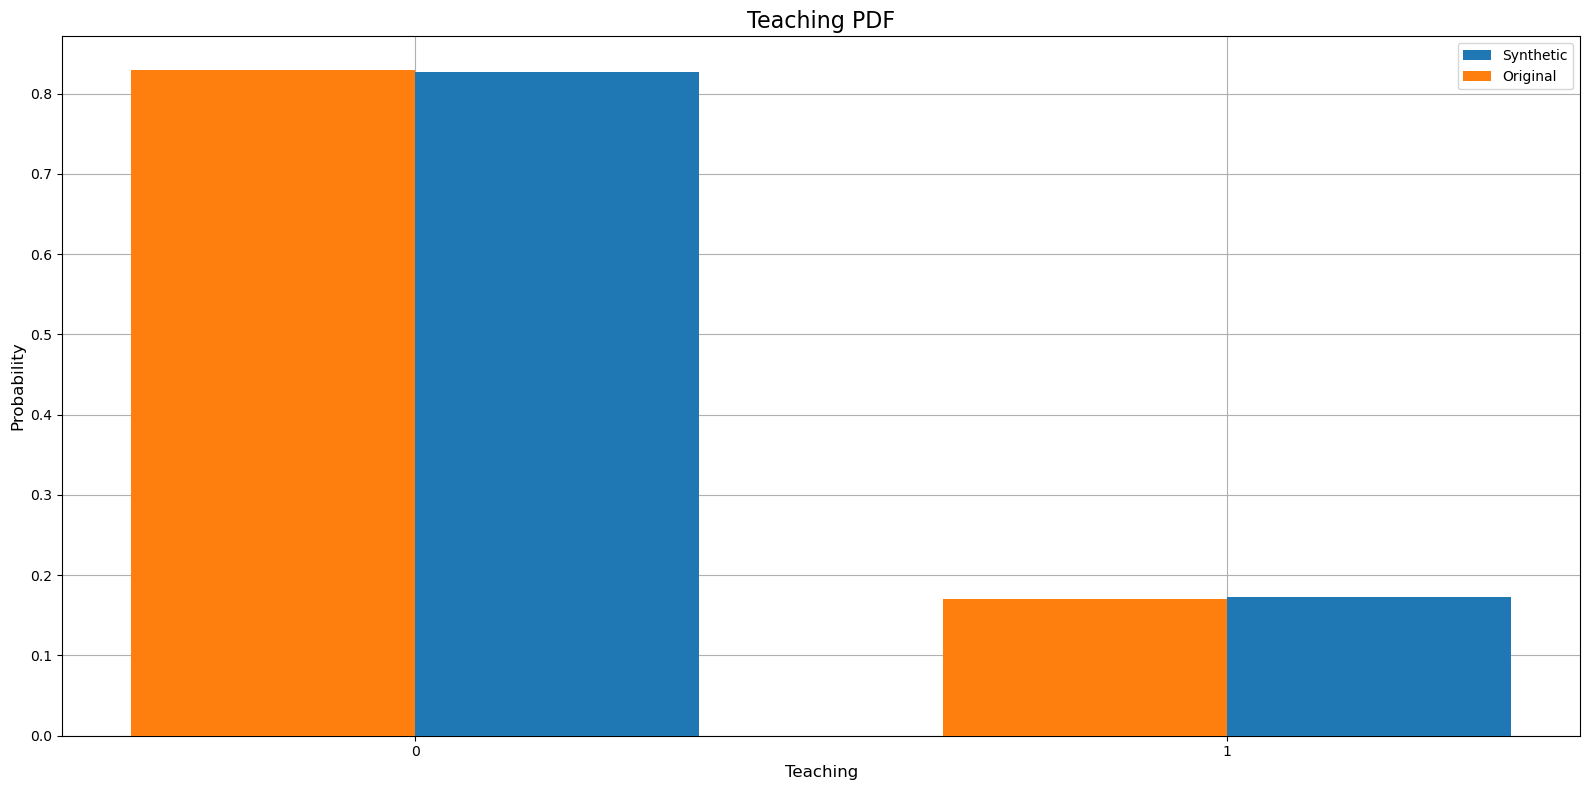

 Original PDF : [0.83 0.17]
Synthetic PDF : [0.827 0.173]


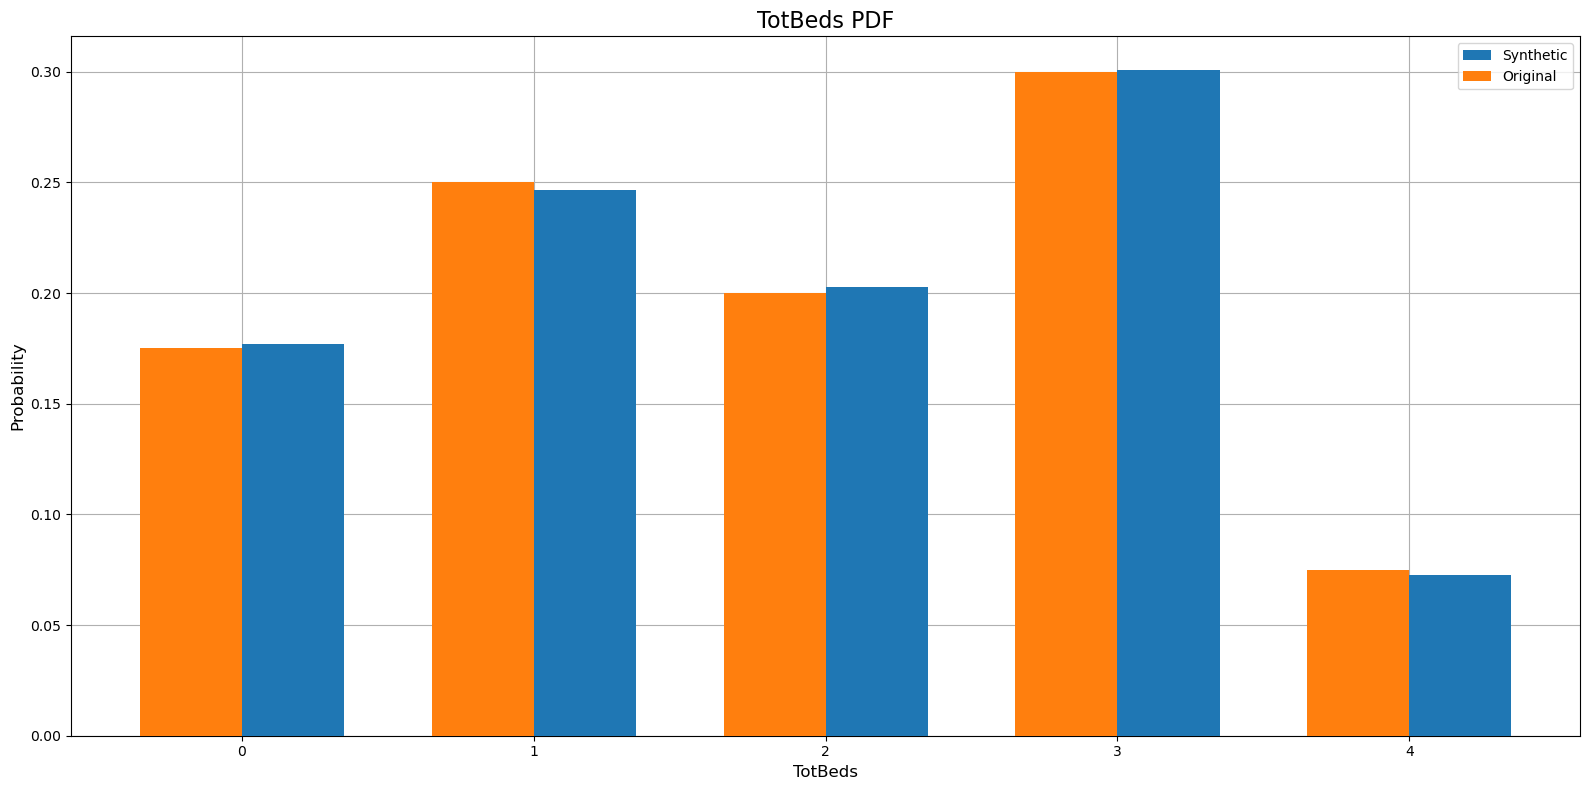

 Original PDF : [0.175 0.25  0.2   0.3   0.075]
Synthetic PDF : [0.177 0.246 0.203 0.301 0.073]


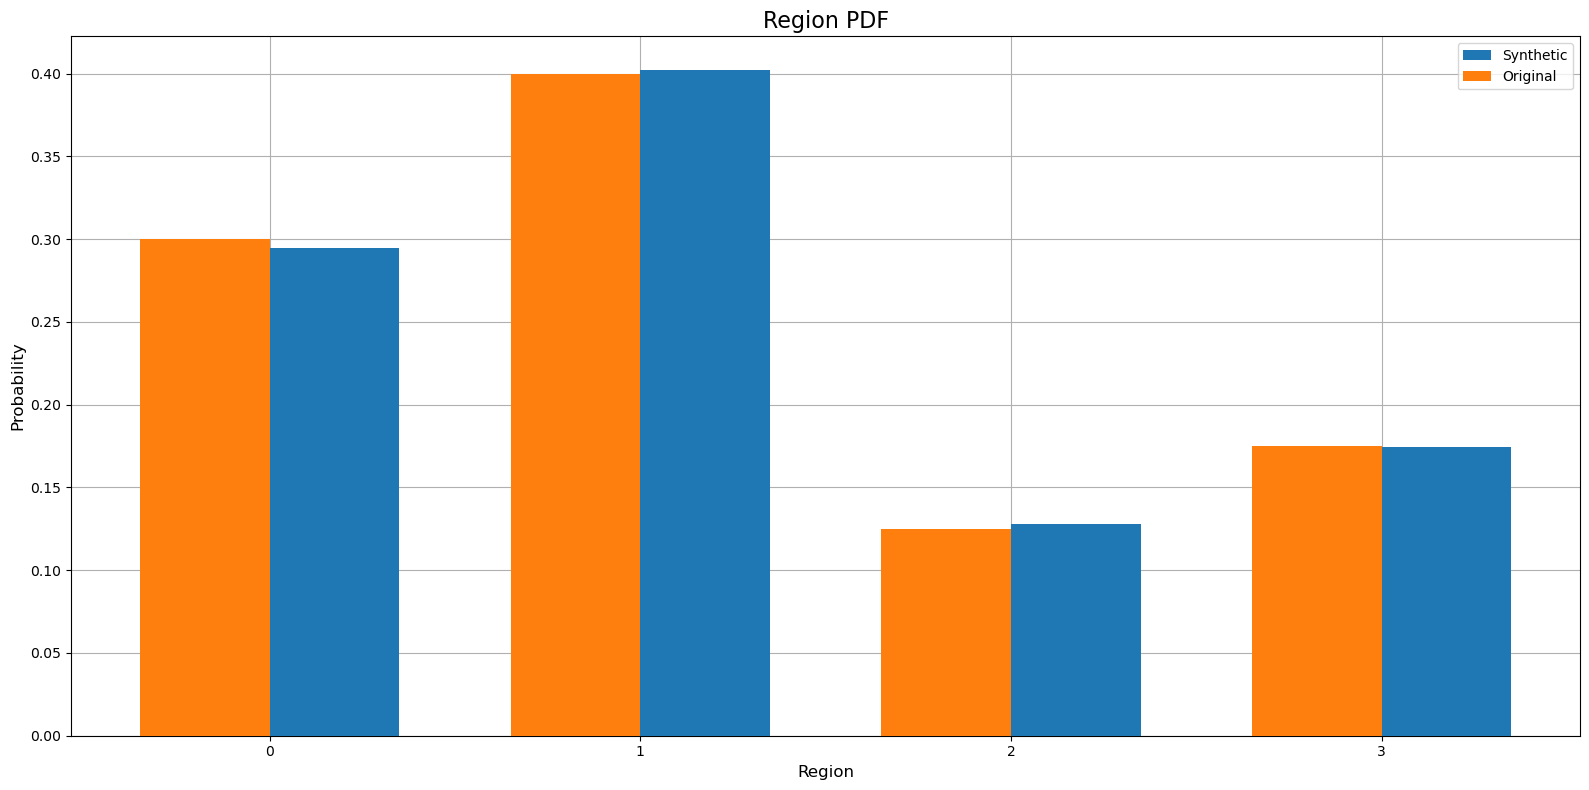

 Original PDF : [0.3   0.4   0.125 0.175]
Synthetic PDF : [0.295 0.402 0.128 0.175]


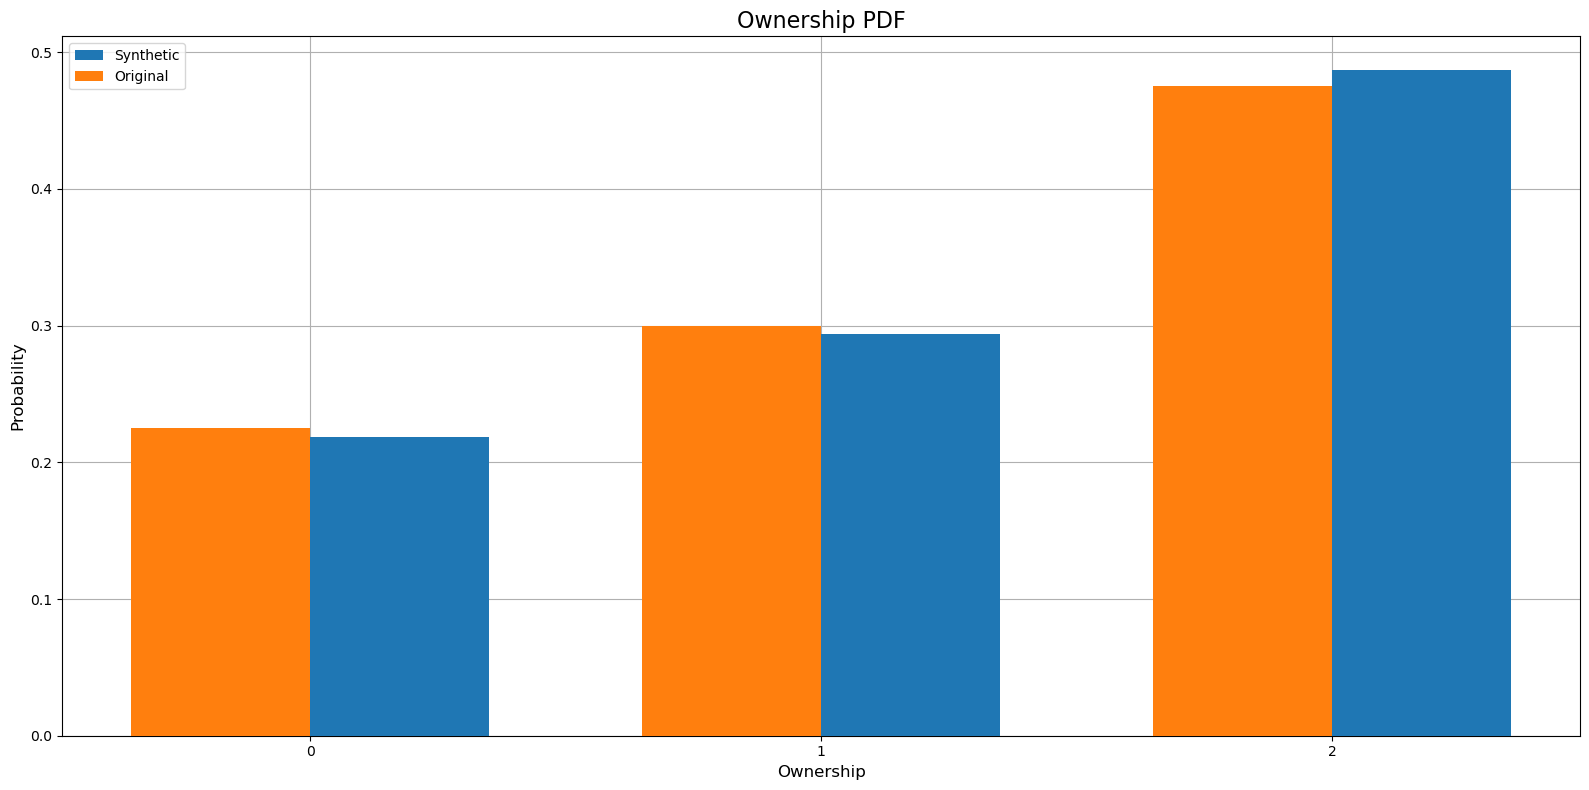

 Original PDF : [0.225 0.3   0.475]
Synthetic PDF : [0.219 0.294 0.487]


In [15]:
# display precision
P = 3

for i, var_name in enumerate(VARIABLES):
    plots.dual_histogram_from_pdfs(var_name, orig_pdfs[var_name], synth_pdfs[var_name],
                                   labels=['Original', 'Synthetic'])
    
    print(' Original PDF : {0}'.format(np.array_str(orig_pdfs[var_name],  precision=P)))
    print('Synthetic PDF : {0}'.format(np.array_str(synth_pdfs[var_name], precision=P)))

#### Write Synthetic Tuples to Disk

In [16]:
output_df.to_csv(OUTPUT_FILE, index=False)
print('Wrote file "{0}".'.format(OUTPUT_FILE))

Wrote file "synthetic_hospital_target.csv".
